In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

### Data

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

### Model

In [ ]:
loss_func = F.cross_entropy

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(m, nh, 10)

In [ ]:
pred = model(x_train)

In [ ]:
loss = loss_func(pred, y_train)

In [ ]:
loss.backward()

## Basic training loop

In [ ]:
#export
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [ ]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.0643, -0.2629, -0.0244, -0.0575, -0.1061, -0.0464, -0.0758, -0.0408,
         -0.1190,  0.0563], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [ ]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3019, grad_fn=<NllLossBackward>)

In [ ]:
accuracy(preds, yb)

tensor(0.1094)

In [ ]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1603, grad_fn=<NllLossBackward>), tensor(0.9375))

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [ ]:
model = Model(m, nh, 10)
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [ ]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(layers)

In [ ]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(layers)

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1561, grad_fn=<NllLossBackward>), tensor(0.9531))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1267, grad_fn=<NllLossBackward>), tensor(0.9531))

### optim

Pytorch also has a package with various optimization algorithms, `torch.optim`. We can use the `step` method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

(`optim.zero_grad()` resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)

In [ ]:
#export
from torch import optim

In [ ]:
def get_model():
    model = Model(m, nh, 10)
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2643, grad_fn=<NllLossBackward>)

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0686, grad_fn=<NllLossBackward>), tensor(1.))

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [ ]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [ ]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
len(train_ds),len(valid_ds)

(50000, 10000)

In [ ]:
train_ds[0:5]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [ ]:
model,opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2172, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    pred = model(xb)
```

In [ ]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
x,y = next(iter(valid_dl))

tensor(3)

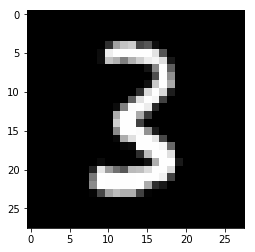

In [ ]:
plt.imshow(x[0].view(28,28))
y[0]

In [ ]:
model,opt = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [ ]:
fit()

In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [ ]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [ ]:
class DataLoader():
    def __init__(self, ds, sampler): self.ds,self.sampler = ds,sampler
        
    def __iter__(self):
        for s in self.sampler: yield collate([self.ds[i] for i in s])

In [ ]:
class Sampler():
    def __init__(self, ds, bs, is_rand=False):
        self.n,self.bs,self.is_rand = len(ds),bs,is_rand
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.is_rand else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [ ]:
small_ds = Dataset(*train_ds[:10])

In [ ]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [ ]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([0, 7, 8]), tensor([5, 4, 9]), tensor([2, 1, 3]), tensor([6])]

In [ ]:
train_samp = Sampler(train_ds, bs, False)
valid_samp = Sampler(valid_ds, bs, False)

In [ ]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

tensor(3)

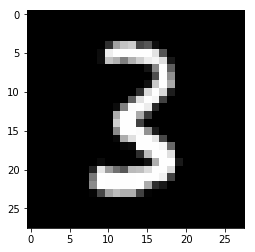

In [ ]:
x,y = next(iter(valid_dl))
plt.imshow(x[0].view(28,28))
y[0]

tensor(2)

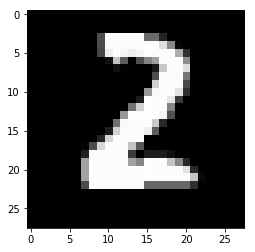

In [ ]:
x,y = next(iter(train_dl))
plt.imshow(x[0].view(28,28))
y[0]

tensor(3)

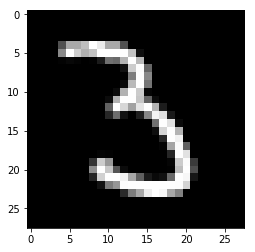

In [ ]:
x,y = next(iter(train_dl))
plt.imshow(x[0].view(28,28))
y[0]

In [ ]:
model,opt = get_model()

In [ ]:
fit()

In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1403, grad_fn=<NllLossBackward>), tensor(0.9375))

### PyTorch DataLoader

In [ ]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

PyTorch's defaults work fine for most things however:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)

`get_dls` returns dataloaders for the training and validation sets.

In [ ]:
#export
def get_dls(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2923) tensor(0.9085)
1 tensor(0.1295) tensor(0.9626)
2 tensor(0.2063) tensor(0.9387)
3 tensor(0.1073) tensor(0.9694)
4 tensor(0.1467) tensor(0.9593)


## Export

In [ ]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to nb_03.py
